In [1]:
import torch
import os
import sys
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
from glob import glob

sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")
from srsphere.models.Unet import Unet
from srsphere.models.ddpm import DDPM
from srsphere.diffusion.scheduler import TimestepSampler
from srsphere.params import set_params

from srsphere.dataset.fits_dataset import MapDataset, denormalize_diff, denormalize
from srsphere.generation.gen_strategy import GenerationStrategy

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set path to the checkpoint
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
ckpt_dir = f"{base_dir}/ckpt_logs/n100_s512_o8_b32_dTrue_concat_batch_silu_aFalse_mTrue_cosine_t2000/version_0"
ckpt_path = sorted(glob(f"{ckpt_dir}/checkpoints/*.ckpt"), key=lambda x: float(x.split('=')[-1].rsplit('.', 1)[0]))[-1]

In [3]:
# load parameters
from generate import parse_fname
pl.seed_everything(1234)
args = parse_fname(ckpt_dir.split('/')[-2])

# for validation
params = set_params(**args)
params['valid'] = {}
params['valid']['save_dir'] = f"{base_dir}/results/imgs/diffusion/{ckpt_dir.split('/')[-2]}"
os.makedirs(params['valid']['save_dir'], exist_ok=True)
params['valid']['timesteps'] = 1200

[rank: 0] Global seed set to 1234


In [4]:
# load dataset
dataset = MapDataset(lrdir=params['data']['LR_dir'], hrdir=params['data']['HR_dir'], n_maps=1, norm=params['data']['norm'], order=None, difference=params['data']['difference'], upsample_scale=params['data']['upsample_scale']**3)
cond = dataset.lrmaps[0].reshape(-1)

In [5]:
#get sampler type
sampler = TimestepSampler(timesteps=params['diffusion']['timesteps'])
#get model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
unet = Unet(params['data']["nside"], params['data']["order"], **params['architecture'])
model = DDPM(unet, sampler, **params['diffusion']).to(device)
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict['state_dict'], strict=False)
model.eval()

The schedule is cosine with s = 0.015


DDPM(
  (model): Unet(
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=64, out_features=64, bias=True)
    )
    (init_conv): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (down_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (emb): TimeEmbed(
            (proj): Linear(in_features=64, out_features=128, bias=True)
            (act): SiLU()
          )
          (in_layers): Sequential(
            (0): Norms(
              (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): Acts(
              (act): SiLU()
            )
            (2): SphericalChebConv(
              (chebconv): ChebConv()
            )
          )
          (pooling): Identity()
          (out_layers): Sequential(
            (0): Norms(
              (

In [6]:
# strategy class for generation
strategy = GenerationStrategy(model, params['data']["nside"], params['data']["order"], params['valid'], cond)

In [9]:
tmp = np.load("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/n100_s512_o8_b32_dTrue_concat_batch_silu_aFalse_mTrue_cosine_t2000/step_000_000.npy")
strategy.img = tmp
strategy._fill_gen_flag(0,0)

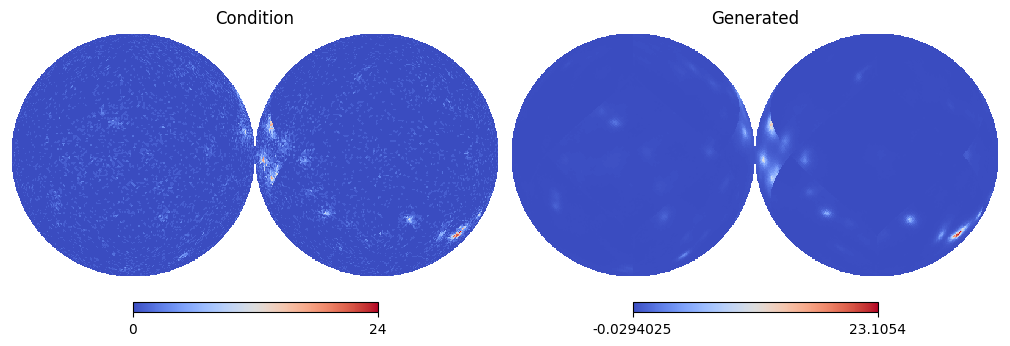

In [12]:
conds, imgs = strategy._prepare_data_tensors(0, 0)
denorm_conds = denormalize(np.hstack(conds.detach().cpu().numpy()[:,:,0]))
denorm_imgs = denormalize_diff(denorm_conds, np.hstack(imgs.detach().cpu().numpy()[:,:,0]))
fig = plt.figure(figsize=(10, 5))
hp.orthview(denorm_conds, title="Condition", sub=(1, 2, 1), cmap="coolwarm", nest=True, fig=fig)
hp.orthview(denorm_imgs, title="Generated", sub=(1, 2, 2),  cmap="coolwarm", nest=True, fig=fig)

In [16]:
count1, count2 = 1, 0
conds, imgs = strategy._prepare_data_tensors(count1, count2)

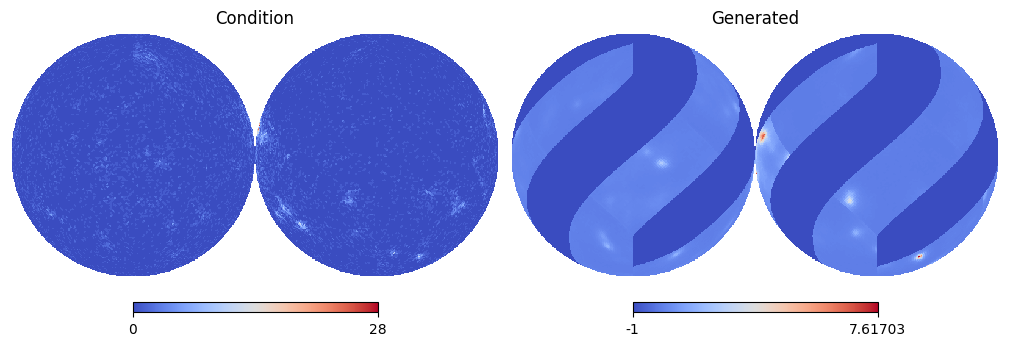

In [17]:
denorm_conds = denormalize(np.hstack(conds.detach().cpu().numpy()[:,:,0]))
denorm_imgs = denormalize_diff(denorm_conds, np.hstack(imgs.detach().cpu().numpy()[:,:,0]))
fig = plt.figure(figsize=(10, 5))
hp.orthview(denorm_conds, title="Condition", sub=(1, 2, 1), cmap="coolwarm", nest=True, fig=fig)
hp.orthview(denorm_imgs, title="Generated", sub=(1, 2, 2),  cmap="coolwarm", nest=True, fig=fig)

In [22]:
strategy._generate_and_update(1, 0)

Diffusion:   4%|▍         | 51/1200 [00:34<13:02,  1.47it/s]

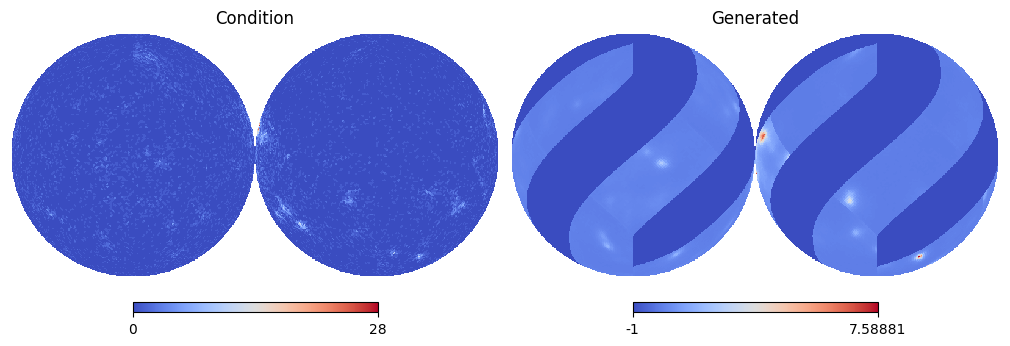

In [ ]:
count1, count2 = 1, 0
conds, imgs = strategy._prepare_data_tensors(count1, count2)
denorm_conds = denormalize(np.hstack(conds.detach().cpu().numpy()[:,:,0]))
denorm_imgs = denormalize_diff(denorm_conds, np.hstack(imgs.detach().cpu().numpy()[:,:,0]))
fig = plt.figure(figsize=(10, 5))
hp.orthview(denorm_conds, title="Condition", sub=(1, 2, 1), cmap="coolwarm", nest=True, fig=fig)
hp.orthview(denorm_imgs, title="Generated", sub=(1, 2, 2),  cmap="coolwarm", nest=True, fig=fig)